In [1]:
import cv2
from matplotlib import pyplot as plt
from random import random
import cairo
import numpy as np
import math
%matplotlib inline
import time

In [2]:
def load_image(path):
    Image1 = cv2.imread(path)
    Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
    return Image1
def show_image(image, gray=False):
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()

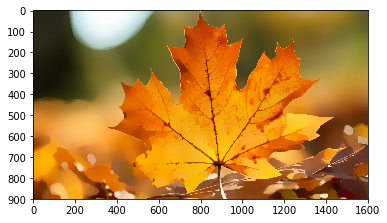

In [3]:
input_image = load_image('./images/intermediate/segmented/leaf-seg_20_13.png')
show_image(input_image)

## Image Segmentation

In [4]:
def process_image(image):
    canny = cv2.Canny(image,200,300)
    show_image(canny, gray=True)
    
    edges_inv = (255 - canny)
    show_image(edges_inv,gray=True)
    
    dist_transform = cv2.distanceTransform(edges_inv,cv2.DIST_L2,0) 
    show_image(dist_transform,gray=True)
    
    return dist_transform

In [5]:
SIZE_X = input_image.shape[1]
SIZE_Y = input_image.shape[0]
SIZE = min(SIZE_X,SIZE_Y)

LINEWIDTH = 0.1

TWOPI = 2.0*3.14
BACK = [255,0,0,1]


## Functions for creating circles

In [6]:
def add_new_circles(is_fill, dist_map, circles,r,t,e):
    for x in range(2*r,SIZE_X- r):
        for y in range(2*r,SIZE_Y - r):
            a=True
            if dist_map[y,x]>r:
                p=(int)((dist_map[y,x]+1)/2)
                if p>e:
                    p=r
                if (is_fill[x,y]==0)&(x-p>=0)&(x+p<SIZE_X)&(y-p>=0)&(y+p<SIZE_Y):
                    for rt in range(x-p,x+p+1):
                        if rt>SIZE_X:
                            break
                        yu=rt-x
                        for ty in range(y-p,y+p+1):
                            if ty>SIZE_Y:
                                break
                            op=ty-y
                            if yu*yu+op*op<(p+1)*(p+1):
                                if is_fill[rt,ty]==1:
                                    a=False
                                    break
                            if a==False:
                                break
                    
                    if a==True:
                        circles.append({
                        'x': x, 
                        'y': y, 
                        'r': p,
                        }) 
                        for st in range(x-p,x+p+1):
                            ui=st-x
                            if st>SIZE_X:
                                break
                            for en in range(y-p,y+p+1):
                                iu=en-y
                                if en>SIZE_Y:
                                    break
                                if ui*ui+iu*iu<=(p+1)*(p+1):
                                    is_fill[st,en]=1    

                        
                        y=y+p*2+r;

def show(img_clr, back, ctx, circles):
    for c in circles:
        if (not np.array_equal(back[int(c['y']),int(c['x'])],np.array([200,200,200]))):
            rgb = img_clr[int(c['y']),int(c['x'])]
            rgba = [rgb[0]/255, rgb[1]/255,rgb[2]/255, 1.0]
            ctx.set_source_rgba(*rgba)
            ctx.arc(c['x'], c['y'], c['r'], 0, TWOPI)
            ctx.fill()
            ctx.set_source_rgba(*[0,0,0,1])
            ctx.arc(c['x'], c['y'], c['r'], 0, TWOPI)
            ctx.stroke()
        else:
            rgb = img_clr[int(c['y']),int(c['x'])]
            rgba = [rgb[0]/255, rgb[1]/255,rgb[2]/255, 0.7]
            ctx.set_source_rgba(*rgba)
            ctx.arc(c['x'], c['y'], c['r'], 0, TWOPI)
            ctx.fill()
            ctx.set_source_rgba(*[0,0,0,1])


In [7]:
def run_circlism(image):
    processed_image = process_image(image)
    back = cv2.imread('images/intermediate/background/leaf_back.png')
    s = time.time()
    image = cairo.ImageSurface.create_from_png('./images/intermediate/background/leaf_back.png')
    buffer_surf = cairo.ImageSurface(cairo.FORMAT_ARGB32, SIZE_X, SIZE_Y)
    buffer = cairo.Context(buffer_surf)
    buffer.set_source_surface(image, 0,0)
    # buffer.set_source_rgba(0,0,0,1)
    buffer.paint()

    # buffer.scale(SIZE_X, SIZE_Y)

    buffer.rectangle(0.0, 0.0, 1.0, 1.0)
    buffer.fill()
    circles = []
    is_fill = np.zeros([SIZE_X+1,SIZE_Y+1])
    D = [ 50,20,10, 5, 3, 2]
    add_new_circles(is_fill, processed_image, circles,50,50,500)
    print(time.time()-s)
    for i in range(len(D)):
        if i==0:
            continue
        add_new_circles(is_fill, processed_image, circles,D[i],D[i],D[i-1])
        print(time.time()-s)

    buffer.set_line_width(1)
    show(input_image, back, buffer, circles)
    print (len(circles))
    buffer_surf.write_to_png('./images/output/leaf_out.png')
    print (time.time()-s)

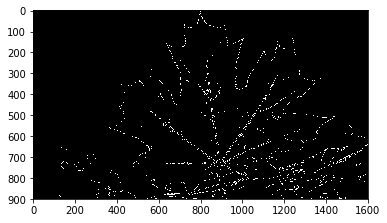

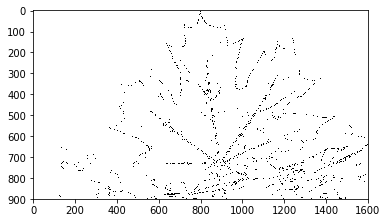

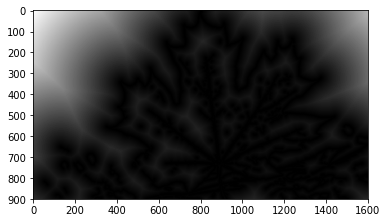

22.207675457000732
44.396583795547485


In [ ]:
run_circlism(input_image)

In [ ]:
result = cv2.imread('./images/output/leaf_out.png')
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(result)
plt.title('EDT Circle Packing')
plt.show()